<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [8]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [9]:
import requests
import bs4
from bs4 import BeautifulSoup
import time

In [10]:
URL = "https://www.indeed.com/jobs?q=data+science&l=Hialeah%2C+FL&radius=10"
#conducting a request of the stated URL above:
page = requests.get(URL)
#specifying a desired format of “page” using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
soup = BeautifulSoup(page.text, "html.parser")
#printing soup in a more structured tree format that makes for easier reading
#print(soup.prettify())

In [11]:
def extract_job_title_from_result(soup): 
    jobs = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
        for a in div.find_all(name="a", attrs={"data-tn-element":"jobTitle"}):
            jobs.append(a["title"])
    return(jobs)
extract_job_title_from_result(soup)

['Manager, Data Science & Engineering',
 'Data Engineer',
 'Big Data/ETL Automation Test Engineer',
 'AI/Machine Learning/Coding Enthusiast',
 'Data Scientist, Data Analytics & AI',
 'Associate Data Scientist',
 'Data Scientist',
 'Senior Manager, Data Science & Analytics',
 'Artificial Intelligence/Analytics Data Scientist - Consultant',
 'Research Data Engineer',
 'Sales & Marketing Business Analyst',
 'Data Analytics Engineer',
 'Data Scientist (Intelligence)',
 'Sr. Data Scientist',
 'Research Data Engineer']

In [12]:
def extract_summary_from_result(soup): 
    summaries = []
    style="list-style-type:circle;margin-top: 0px;margin-bottom: 0px;padding-left:20px;"
    #spans = soup.findAll("div", attrs={"class": "summary"})
    for row in soup.find_all(name="div", attrs={"class":"row"}):
        for div in row.findAll("div", attrs={"class": "summary"}):
                for ul in div.findAll(["ul", "/ul"], attrs={"style": style}):
                    summaries.append(ul.text.strip())
                
    return summaries
extract_summary_from_result(soup)

['Solid knowledge of current technology data architecture, particularly data lakes and cloud environments.Reporting to the Director of Enterprise Analytics, the…',
 'Work with data science teams and with business (data) analysts to refine their data requirements for various data and analytics initiatives.',
 'Understanding of data analysis, data modeling, database design, data migration and business intelligence solutions.Experience in analyzing & validating data.',
 'Anyone who is hungry to positively impact society using Artificial Intelligence (AI) & Machine Learning (ML).Some experience in Machine Learning.',
 'This Data Scientist will focus on architecting, deploying and evaluating intelligent solutions as part of a growing Data Science team within Royal Caribbean.',
 '2+ years of experience as a data scientist or highly technical data analyst.Strong skills in data extraction and transformation with SQL.',
 'The data scientist will also need to integrate data from disparate source

In [13]:
max_results_per_city = 100
city_set = ["San+Francisco", "Washington+DC","Austin","Seattle","Baltimore","New+York",
            "Miami", "Denver", "Portland", "Chicago", "Atlanta", "Seattle", "Los+Angeles"]
columns = ["city","job_title","summary"]
sample_df = pd.DataFrame(columns = columns)

In [14]:
#scraping code:
for city in city_set:
    for start in range(0, max_results_per_city, 10):
        page = requests.get('http://www.indeed.com/jobs?q=data+scientist+junior&l=' + str(city) + '&start=' + str(start))
        time.sleep(1)  #ensuring at least 1 second between page grabs
        soup = BeautifulSoup(page.text, "html.parser", from_encoding="utf-8")
        for div in soup.find_all(name="div", attrs={"class":"row"}):
            #specifying row num for index of job posting in dataframe
            num = (len(sample_df) + 1)
            #creating an empty list to hold the data for each posting
            job_post = []
            #append city name
            job_post.append(city)
            #grabbing job title
            for a in div.find_all(name="a", attrs={"data-tn-element":"jobTitle"}):
                job_post.append(a["title"])
            #grabbing summary text
            d = div.findAll("span", attrs={"class":"summary"})
#             for span in d:
#                 job_post.append(span.text.strip())
            style="list-style-type:circle;margin-top: 0px;margin-bottom: 0px;padding-left:20px;"
            for b in div.findAll("div", attrs={"class": "summary"}):
                for ul in b.findAll(["ul", "/ul"], attrs={"style": style}):
                    job_post.append(ul.text.strip())
            #appending list of job post info to dataframe at index num
            sample_df.loc[num] = job_post

C:\ProgramData\Anaconda3\envs\U4-S1-NLP\lib\site-packages\bs4\__init__.py:191: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


In [15]:
sample_df.head()

,city,job_title,summary
1,San+Francisco,Principal Data Scientist,Title: Principal Data Scientist - 61756.Work w...
2,San+Francisco,Biophysicist/Physical Chemist-PhD Degree Required,Lead and manage a small team (2-3 junior scien...
3,San+Francisco,Sr. Scientist,Provide guidance and supervise junior research...
4,San+Francisco,Associate Director-CAR-T,Get up in front of senior partners and present...
5,San+Francisco,Associate Data Scientist,The Jr. Data Scientist will dig into data to u...


In [16]:
sample_df.summary[1]

'Title: Principal Data Scientist - 61756.Work with large geospatial data, including high resolution satellite imagery and environmental data.'

In [121]:
##### Your Code Here #####
# raise Exception("\nThis task is not complete. \nReplace this line with your code for the task.")
                
# from bs4 import BeautifulSoup
# import requests

## 2) Use Spacy to tokenize / clean the listings 

In [17]:
##### Your Code Here #####
nlp = spacy.load("en_core_web_lg")

In [18]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [19]:
df = sample_df.copy()
df.head()

,city,job_title,summary
1,San+Francisco,Principal Data Scientist,Title: Principal Data Scientist - 61756.Work w...
2,San+Francisco,Biophysicist/Physical Chemist-PhD Degree Required,Lead and manage a small team (2-3 junior scien...
3,San+Francisco,Sr. Scientist,Provide guidance and supervise junior research...
4,San+Francisco,Associate Director-CAR-T,Get up in front of senior partners and present...
5,San+Francisco,Associate Data Scientist,The Jr. Data Scientist will dig into data to u...


In [20]:
df['lemmas'] = df['summary'].apply(get_lemmas)
df_test = df['summary'].apply(get_lemmas)

In [21]:
df_test.head()

1    [title, Principal, Data, Scientist, 61756.work...
2    [lead, manage, small, team, 2, 3, junior, seek...
3    [provide, guidance, supervise, junior, researc...
4    [senior, partner, present, datum, manage, ment...
5    [Jr., Data, Scientist, dig, datum, uncover, in...
Name: summary, dtype: object

In [22]:
df.summary[2]

'Lead and manage a small team (2-3 junior scientists).We are seeking a highly-motivated and risk-taking biophysicist/physical chemist to take a key role in…'

In [23]:
df.lemmas[2]

['lead',
 'manage',
 'small',
 'team',
 '2',
 '3',
 'junior',
 'seek',
 'highly',
 'motivated',
 'risk',
 'take',
 'biophysicist',
 'physical',
 'chemist',
 'key',
 'role']

In [28]:
jobs_summary_lemmas = []
for set_of_lemmas in df['lemmas'].values:
    working_set = ""
    for lemma in set_of_lemmas:
        working_set += lemma + ' '
    jobs_summary_lemmas.append(working_set)

In [44]:
jobs_summary_lemmas[0:10]

['title Principal Data Scientist 61756.work large geospatial datum include high resolution satellite imagery environmental datum ',
 'lead manage small team 2 3 junior seek highly motivated risk take biophysicist physical chemist key role ',
 'provide guidance supervise junior research associate aspect analytical laboratory operation sample receipt datum generation ',
 'senior partner present datum manage mentor junior Scientists Associate organization aggressively build ',
 'Jr. Data Scientist dig datum uncover insight design experiment measure impact contribute long term product strategy ',
 'responsibility Data Scientist include qualification Data Scientist include compensation Data Scientist include ',
 'provide coaching mentoring junior level datum scientist experience work following r Python SAS datum manipulation ',
 'individual execute radiation health safety survey control process high technical datum integrity standard set forth ',
 'convey idea guide execution mentor junior 

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [41]:
##### Your Code Here #####
vect = CountVectorizer(stop_words='english')
vect.fit(jobs_summary_lemmas)
dtm = vect.transform(jobs_summary_lemmas)
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.head()

,00,046713,10,11,20,2020,20407,21,24,30,...,writer,writing,wtih,www,xcalar,year,years,york,zerofox,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [67]:
from collections import Counter
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [74]:
wc = count(df['lemmas'])
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
3,datum,1151,1713,1.0,0.066522,0.066522,0.665703
14,junior,694,717,2.0,0.027844,0.094365,0.401388
71,experience,436,466,3.0,0.018096,0.112462,0.252169
2,Data,312,429,4.0,0.016660,0.129121,0.180451
209,data,350,371,5.0,0.014407,0.143528,0.202429
50,mentor,353,363,6.0,0.014097,0.157625,0.204164
70,scientist,322,348,7.0,0.013514,0.171139,0.186235
1,Scientist,309,341,8.0,0.013242,0.184381,0.178716
19,team,303,325,9.0,0.012621,0.197002,0.175246
76,work,296,322,10.0,0.012504,0.209506,0.171197


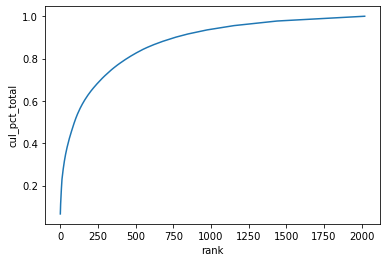

In [69]:
import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

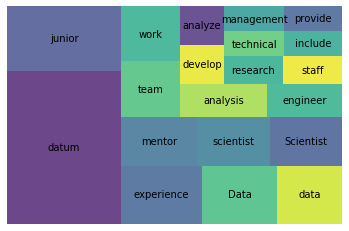

In [73]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [96]:
STOP_WORDS = nlp.Defaults.stop_words.union(['datum', 'junior', 'Data', 'data', 'scientist',
                                            'Scientist', 'science', 'machine'])

In [97]:
from spacy.tokenizer import Tokenizer

tokenizer = Tokenizer(nlp.vocab)
tokens = []

for doc in tokenizer.pipe(jobs_summary_lemmas, batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['tokens'] = tokens

In [98]:
df.head()

,city,job_title,summary,lemmas,tokens
1,San+Francisco,Principal Data Scientist,Title: Principal Data Scientist - 61756.Work w...,"[title, Principal, Data, Scientist, 61756.work...","[title, principal, 61756.work, large, geospati..."
2,San+Francisco,Biophysicist/Physical Chemist-PhD Degree Required,Lead and manage a small team (2-3 junior scien...,"[lead, manage, small, team, 2, 3, junior, seek...","[lead, manage, small, team, 2, 3, seek, highly..."
3,San+Francisco,Sr. Scientist,Provide guidance and supervise junior research...,"[provide, guidance, supervise, junior, researc...","[provide, guidance, supervise, research, assoc..."
4,San+Francisco,Associate Director-CAR-T,Get up in front of senior partners and present...,"[senior, partner, present, datum, manage, ment...","[senior, partner, present, manage, mentor, sci..."
5,San+Francisco,Associate Data Scientist,The Jr. Data Scientist will dig into data to u...,"[Jr., Data, Scientist, dig, datum, uncover, in...","[jr., dig, uncover, insight, design, experimen..."


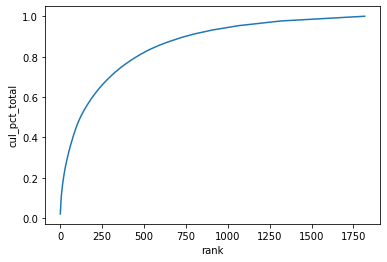

In [99]:
wc = count(df['tokens'])
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

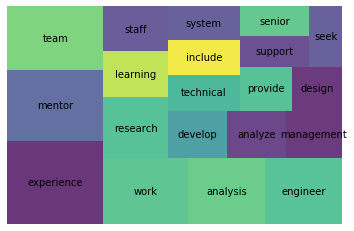

In [100]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [39]:
##### Your Code Here #####
def tokenize(document):
    doc = nlp(document)
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Instantiate vectorizer object
tfidf = TfidfVectorizer(tokenizer=tokenize, min_df=0.025, max_df=.98, ngram_range=(1,2))
# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(df.summary) # Similiar to fit_predict
# Print word counts
# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())
# View Feature Matrix as DataFrame
dtm.head()

,+,+ year,ability,algorithm,analysis,analyst,analytic,analytical,analyze,application,...,technical support,technology,tool,training,training technical,use,visualization,web,work,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.425028,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [53]:
##### Your Code Here #####
from sklearn.neighbors import NearestNeighbors

# Fit on TF-IDF Vectors
nn  = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [54]:
nn.kneighbors([dtm.iloc[30]])

(array([[0., 0., 0., 0., 0.]]),
 array([[ 88,   0,  45, 148,  30]], dtype=int64))

In [55]:
sample_df.summary[30]

'Experience building teams and coaching and mentoring more junior scientists.The team currently has research programs across several therapeutic areas,…'

In [56]:
sample_df.summary[88]

'Experience building teams and coaching and mentoring more junior scientists.The team currently has research programs across several therapeutic areas,…'

In [57]:
ideal_job_description = ["junior small team good pay learning opportunity"]

In [58]:
new = tfidf.transform(ideal_job_description)

In [59]:
nn.kneighbors(new.todense())

(array([[0.97186169, 1.        , 1.02403518, 1.02403518, 1.02403518]]),
 array([[1196, 1265,   87,   32,  147]], dtype=int64))

In [64]:
sample_df.summary[147]

'Provide guidance and supervise junior research associates.All aspects of analytical laboratory operations, such as sample receipt, data generation,…'

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 